<a href="https://colab.research.google.com/github/CelikAbdullah/my-deep-learning-notebooks/blob/main/image%20classification/Image_Classification_CIFAR_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from tensorflow import keras
import matplotlib.pyplot as plt

In [17]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

In [18]:
assert x_train.shape == (50000, 32, 32, 3)
assert x_test.shape == (10000, 32, 32, 3)
assert y_train.shape == (50000, 1)
assert y_test.shape == (10000, 1)

In [19]:
x_train.dtype

dtype('uint8')

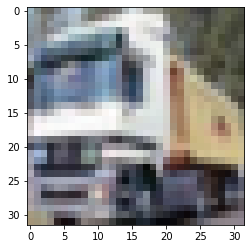

In [20]:
plt.imshow(x_train[1], cmap=plt.get_cmap('gray'))
plt.show()

# Creating the validation dataset

In [21]:
x_val = x_train[:10000]
x_train = x_train[10000:]

y_val = y_train[:10000]
y_train = y_train[10000:]

# One-hot encoding of the targets

In [24]:
y_train = keras.utils.to_categorical(y_train)
y_val = keras.utils.to_categorical(y_val)
y_test = keras.utils.to_categorical(y_test)


# Data augmentation

In [26]:
data_augmentation = keras.Sequential(
    [
     keras.layers.RandomFlip("horizontal"),
     keras.layers.RandomFlip("vertical"),
     keras.layers.RandomRotation(0.1),
    ]
)

# Building the model

In [27]:
# a helper function 
def residual_block(x, num_filters, pooling = False):
  # residual is pointing to the original input
  residual = x

  # a block containing conv layers
  x = keras.layers.SeparableConv2D(num_filters, 3, padding="same", use_bias=False)(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Activation("relu")(x)
  x = keras.layers.SeparableConv2D(num_filters, 3, padding="same", use_bias=False)(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Activation("relu")(x)
  x = keras.layers.SeparableConv2D(num_filters, 3, padding="same", use_bias=False)(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Activation("relu")(x)

  if pooling: 
    x = keras.layers.MaxPooling2D(2, padding="same")(x)
    residual = keras.layers.Conv2D(num_filters, 1, strides=2)(residual)

  elif num_filters != residual.shape[-1]:
    residual = keras.layers.Conv2D(num_filters, 1)(residual)

  x = keras.layers.add([x, residual])

  return x

In [28]:
num_classes = 10

inputs = keras.Input(shape=(32,32,3))

augmented_inputs = data_augmentation(inputs)

rescaled_inputs = keras.layers.Rescaling(1.0/255)(augmented_inputs)

x = keras.layers.Conv2D(16,3,padding="same", use_bias=False)(rescaled_inputs)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(2)(x)


x = residual_block(x, 16, False)
x = residual_block(x, 16, False)
x = residual_block(x, 16, False)
x = residual_block(x, 16, True)
x = residual_block(x, 32, False)
x = residual_block(x, 32, False)
x = residual_block(x, 32, False)
x = residual_block(x, 32, True)
x = residual_block(x, 48, False)
x = residual_block(x, 48, False)
x = residual_block(x, 48, False)
x = residual_block(x, 48, True)
x = residual_block(x, 64, False)
x = residual_block(x, 64, False)
x = residual_block(x, 64, False)
x = residual_block(x, 64, True)

x = keras.layers.Flatten()(x)
x = keras.layers.Dense(64, activation="relu")(x)
x = keras.layers.Dropout(0.5)(x)
outputs = keras.layers.Dense(num_classes, activation="softmax")(x)

cifar10_model = keras.Model(inputs=inputs, outputs=outputs, name="cifar10_model")

In [29]:
cifar10_model.summary()

Model: "cifar10_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 sequential (Sequential)        (None, 32, 32, 3)    0           ['input_1[0][0]']                
                                                                                                  
 rescaling (Rescaling)          (None, 32, 32, 3)    0           ['sequential[0][0]']             
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 16)   432         ['rescaling[0][0]']              
                                                                                      

# Compiling the model

In [30]:
optimizer = keras.optimizers.Adam(learning_rate=0.001)
loss = "categorical_crossentropy"
metrics = ["accuracy"]

cifar10_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

# Setting up some callbacks

In [31]:
callbacks = [
             keras.callbacks.ModelCheckpoint("/content/drive/MyDrive/fashion_mnist/model_for_cifar_10_img_classification", 
                                             save_best_only=True, 
                                             monitor ="val_loss"), 
             keras.callbacks.EarlyStopping(patience=10)
]

# Training the model

In [32]:
epoch_nr = 100
batch_size = 128
validation_data = (x_val, y_val)

history_cifar10_model = cifar10_model.fit(x=x_train, y=y_train, epochs=epoch_nr, batch_size=batch_size, validation_data=validation_data, callbacks=callbacks)

Epoch 1/100
313/313 [==============================] - 223s 687ms/step - loss: 2.2362 - accuracy: 0.1819 - val_loss: 2.3037 - val_accuracy: 0.1107
Epoch 2/100
313/313 [==============================] - 219s 699ms/step - loss: 1.9707 - accuracy: 0.2631 - val_loss: 1.7828 - val_accuracy: 0.3409
Epoch 3/100
313/313 [==============================] - 197s 630ms/step - loss: 1.8452 - accuracy: 0.3171 - val_loss: 1.8710 - val_accuracy: 0.3077
Epoch 4/100
313/313 [==============================] - 219s 699ms/step - loss: 1.7567 - accuracy: 0.3551 - val_loss: 1.6137 - val_accuracy: 0.4046
Epoch 5/100
313/313 [==============================] - 219s 701ms/step - loss: 1.6840 - accuracy: 0.3899 - val_loss: 1.5310 - val_accuracy: 0.4381
Epoch 6/100
313/313 [==============================] - 196s 627ms/step - loss: 1.6233 - accuracy: 0.4133 - val_loss: 1.5480 - val_accuracy: 0.4396
Epoch 7/100
313/313 [==============================] - 193s 615ms/step - loss: 1.5839 - accuracy: 0.4323 - val_loss: 1

# Plotting the results

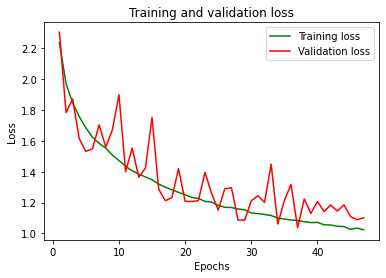

In [33]:
history = history_cifar10_model.history

train_loss = history["loss"]
val_loss = history["val_loss"]

train_acc = history["accuracy"]
val_acc = history["val_accuracy"]

epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, linestyle="solid", color="green", label="Training loss")
plt.plot(epochs, val_loss, linestyle="solid", color="red", label="Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

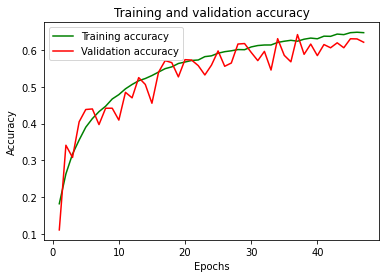

In [34]:
plt.plot(epochs, train_acc, linestyle="solid", color="green", label="Training accuracy")
plt.plot(epochs, val_acc, linestyle="solid", color="red", label="Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.show()

# Load the model

In [35]:
cifar10_model = keras.models.load_model("/content/drive/MyDrive/fashion_mnist/model_for_cifar_10_img_classification")

# Evaluate the model

In [36]:
test_loss, test_accuracy = cifar10_model.evaluate(x=x_test, y=y_test)

313/313 [==============================] - 13s 37ms/step - loss: 1.0677 - accuracy: 0.6364


In [39]:
print(f"Test accuracy on new unseen data is {test_accuracy * 100}%")

Test accuracy on new unseen data is 63.63999843597412%
